In [351]:
import numpy as np
import pandas as pd
import sqlite3

Import data from the local SQLite database included in the GitHub
Three Tables: ORDER_DETAIL, ITEM_MASTER, CUSOTMER_MASTER

In [352]:
#readin data from db
#establish connection
connection = sqlite3.connect('/Users/michaelcolellajensen/Downloads/pythonsqlite_PHI_superstore.db')
cursor = connection.cursor()

#test connection
cursor.execute('SELECT * FROM CUSTOMER_MASTER LIMIT 1')
cursor.description

(('CUSTOMER_ID', None, None, None, None, None, None),
 ('CUSTOMER_NAME', None, None, None, None, None, None),
 ('SEGMENT', None, None, None, None, None, None),
 ('SHIP_LOCATION_ID', None, None, None, None, None, None),
 ('COUNTRY', None, None, None, None, None, None),
 ('CITY', None, None, None, None, None, None),
 ('STATE', None, None, None, None, None, None),
 ('REGION', None, None, None, None, None, None))

In [353]:
#See columns for each table 
cursor.execute('SELECT * FROM ORDER_DETAIL LIMIT 1')
cursor.description

(('ORDER_ID', None, None, None, None, None, None),
 ('ORDER_DATE', None, None, None, None, None, None),
 ('SHIP_DATE', None, None, None, None, None, None),
 ('SHIP_MODE', None, None, None, None, None, None),
 ('CUSTOMER_ID', None, None, None, None, None, None),
 ('SHIP_LOCATION_ID', None, None, None, None, None, None),
 ('PRODUCT_ID', None, None, None, None, None, None),
 ('SALES', None, None, None, None, None, None),
 ('QUANTITY', None, None, None, None, None, None),
 ('DISCOUNT', None, None, None, None, None, None),
 ('PROFIT', None, None, None, None, None, None))

In [354]:
cursor.execute('SELECT * FROM ITEM_MASTER LIMIT 1')
cursor.description

(('PRODUCT_ID', None, None, None, None, None, None),
 ('PRODUCT_NAME', None, None, None, None, None, None),
 ('CATEGORY', None, None, None, None, None, None),
 ('SUB_CATEGORY', None, None, None, None, None, None))

Join the three tables together using SQL

In [355]:
#joining tables using sql statements 
query = '''SELECT * 
FROM CUSTOMER_MASTER
JOIN ORDER_DETAIL
ON CUSTOMER_MASTER.CUSTOMER_ID = ORDER_DETAIL.CUSTOMER_ID
JOIN ITEM_MASTER
ON ORDER_DETAIL.PRODUCT_ID = ITEM_MASTER.PRODUCT_ID;
'''
cursor.execute(query)

#sanity check that all columns are included
results = cursor.fetchmany(5)
for record in results:
    print(record)

('CG-12520', 'Claire Gute', 'Consumer', 42420.0, 'United States', 'Henderson', 'Kentucky', 'South', 'CA-2018-164098', '2018-01-26 00:00:00', '2018-01-27 00:00:00', 'First Class', 'CG-12520', 77070.0, 'OFF-ST-10000615', 18.16, 2, 0.2, 1.8160000000000016, 'OFF-ST-10000615', 'SimpliFile Personal File, Black Granite, 15w x 6-15/16d x 11-1/4h', 'Office Supplies', 'Storage')
('CG-12520', 'Claire Gute', 'Consumer', 42420.0, 'United States', 'Henderson', 'Kentucky', 'South', 'US-2016-123918', '2016-10-15 00:00:00', '2016-10-15 00:00:00', 'Same Day', 'CG-12520', 75217.0, 'FUR-FU-10004952', 131.376, 6, 0.6, -95.24760000000002, 'FUR-FU-10004952', 'C-Line Cubicle Keepers Polyproplyene Holder w/Velcro Back, 8-1/2x11, 25/Bx', 'Furniture', 'Furnishings')
('CG-12520', 'Claire Gute', 'Consumer', 42420.0, 'United States', 'Henderson', 'Kentucky', 'South', 'US-2016-123918', '2016-10-15 00:00:00', '2016-10-15 00:00:00', 'Same Day', 'CG-12520', 75217.0, 'OFF-PA-10003001', 5.344, 1, 0.2, 1.8703999999999998,

Use a Python data analysis library to report descriptive statistics by answering the following questions

Please type out any assumptions that you made in answering the questions
My first asumption is that customer IDs are unique to each customer and no customer has multiple IDs


1. How many distinct customers exist on the order detail?
793

In [356]:
#create a pandas df object to work with from sql query
order_detail_query = '''
SELECT *
FROM ORDER_DETAIL
'''
order_detail_df = pd.read_sql_query(order_detail_query, connection)
unique_customers = order_detail_df['CUSTOMER_ID'].nunique()
print(f'There are {unique_customers} unique cusotmer IDs')

There are 793 unique cusotmer IDs


2. What is the average number of unique items ordered by all customers? 
About 12.5 items per customer

In [357]:
#use group by to get a count of unique product ids by customer 
unique_items_by_customer = order_detail_df.groupby('CUSTOMER_ID')['PRODUCT_ID'].nunique()
#average them across customers 
avg_items_purchased = unique_items_by_customer.mean().round(2)
print(f'The average number of items purchased is {avg_items_purchased} per customer')

The average number of items purchased is 12.54 per customer


3. For orders shipped in 2018, what percent of sales dollars came from the item category "Technology"?

In [358]:
#read in a df object of joined tables, ORDERS and ITEMS
#filtered query by date and category
order_item_query = '''
SELECT * 
FROM ORDER_DETAIL
JOIN ITEM_MASTER
ON ORDER_DETAIL.PRODUCT_ID = ITEM_MASTER.PRODUCT_ID
WHERE SHIP_DATE > "2017/12/31"
AND SHIP_DATE < "2019/01/01"
AND CATEGORY = "Technology"
'''
#sum sales for results 
order_item_2018 = pd.read_sql_query(order_item_query, connection)
sales_total = order_item_2018['SALES'].sum().round(2)
print(f'Total sales for 2018 was ${sales_total} for the Technology catergory')

Total sales for 2018 was $262655.94 for the Technology catergory


4. How many orders did we ship by month? Plot this.

In [359]:
import matplotlib.pyplot as plt
import seaborn as sns
#group orders and count the number of Order Ids by month and year to get the number of orders.
order_detail_df['ORDER_DATE'] = pd.to_datetime(order_detail_df['ORDER_DATE'])
orders_by_month = order_detail_df.groupby([order_detail_df.ORDER_DATE.dt.year, 
                                           order_detail_df.ORDER_DATE.dt.month],
                                          as_index=False)['ORDER_ID'].count()

    ORDER_ID
0         79
1         46
2        157
3        135
4        122
5        135
6        143
7        153
8        268
9        159
10       318
11       278
12        58
13        64
14       138
15       160
16       146
17       138
18       140
19       159
20       293
21       166
22       324
23       316
24        89
25        83
26       163
27       170
28       225
29       199
30       201
31       176
32       363
33       196
34       370
35       352
36       155
37       107
38       238
39       203
40       242
41       245
42       226
43       218
44       459
45       298
46       459
47       462


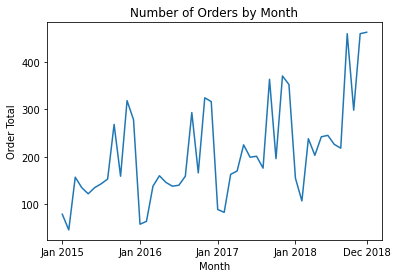

In [360]:
#plot the grouped table using the index of month number and count of orders
#adjusted x axis to reflect the date instead of index 
sns.lineplot(x='index',
            y='ORDER_ID',
            data = orders_by_month.reset_index())
plt.title('Number of Orders by Month')
plt.xlabel('Month')
plt.ylabel('Order Total')
plt.xticks([0,12, 24, 36, 47], 
           ['Jan 2015', 'Jan 2016', 'Jan 2017', 'Jan 2018', 'Dec 2018'])
plt.show()

5. What item was the most profitable in the calendar fourth quarter (combine all years)? 
Canon imageCLASS 2200 Advanced Copier

In [361]:
#filter for 4th quater sales 
orders_details_q4 = order_detail_df[(order_detail_df['ORDER_DATE'].dt.month == 12) |
                                    (order_detail_df['ORDER_DATE'].dt.month == 11) |
                                    (order_detail_df['ORDER_DATE'].dt.month == 10)]
#group the order_detail table by product id and sum profits 
orders_by_product = orders_details_q4.groupby('PRODUCT_ID')['PROFIT']\
    .sum().sort_values(ascending=False).reset_index()
top_product_id = orders_by_product['PRODUCT_ID'][0]

#lookup product details in SQL items_master DB 
item_master_query = '''
SELECT * 
FROM ITEM_MASTER'''
item_master_df = pd.read_sql_query(item_master_query, connection)

#locate the item and print the results
top_product = item_master_df.PRODUCT_NAME[item_master_df['PRODUCT_ID'] == top_product_id]
print(f'The top product of 4th quater by profit is the {top_product}.')

The top product of 4th quater by profit is the 1612    Canon imageCLASS 2200 Advanced Copier
Name: PRODUCT_NAME, dtype: object.


Use an interpretable forecasting algorithm of your choice to predict weekly sales by Category for Calendar 2018 Q4, assuming the model is retrained at the start of each calendar month.

Model Selection: SARIMA model for forecasting seasonal time series data

Assumptions: 
Most data preprocessing is done.
Checking for nulls or NAN values, removing outliers or incorrect data, and normalizing are all complete. 
Assuming that the sales cycle is season every 52 weeks from the graphed data.

Future Reasearch:
Explore different levels of seasonal differencing if there is a trend in the seasonal data.
Further normalize data sources for better results.
Attempt to use xcog data from external or related sources to add features and improve model performance. 

In [373]:
#read in merged date from order_details and items_master
order_items_query = '''
SELECT * 
FROM ORDER_DETAIL
JOIN ITEM_MASTER
ON ORDER_DETAIL.PRODUCT_ID = ITEM_MASTER.PRODUCT_ID
ORDER BY ORDER_DATE'''
order_items_df = pd.read_sql_query(order_items_query, 
                                   connection, 
                                   parse_dates=True)
print(order_items_df.head())
order_items_df['CATEGORY'] = order_items_df['CATEGORY'].str.lower()

         ORDER_ID           ORDER_DATE            SHIP_DATE       SHIP_MODE  \
0  CA-2015-103800  2015-01-03 00:00:00  2015-01-07 00:00:00  Standard Class   
1  CA-2015-112326  2015-01-04 00:00:00  2015-01-08 00:00:00  Standard Class   
2  CA-2015-112326  2015-01-04 00:00:00  2015-01-08 00:00:00  Standard Class   
3  CA-2015-112326  2015-01-04 00:00:00  2015-01-08 00:00:00  Standard Class   
4  CA-2015-141817  2015-01-05 00:00:00  2015-01-12 00:00:00  Standard Class   

  CUSTOMER_ID  SHIP_LOCATION_ID       PRODUCT_ID    SALES  QUANTITY  DISCOUNT  \
0    DP-13000           77095.0  OFF-PA-10000174   16.448         2       0.2   
1    PO-19195           60540.0  OFF-LA-10003223   11.784         3       0.2   
2    PO-19195           60540.0  OFF-ST-10002743  272.736         3       0.2   
3    PO-19195           60540.0  OFF-BI-10004094    3.540         2       0.8   
4    MB-18085           19143.0  OFF-AR-10003478   19.536         3       0.2   

    PROFIT       PRODUCT_ID  \
0   5.5

In [374]:
#accept the input from the user for the category we want to forcast 
category = input('What product category do you want to forcast?')
category = category.lower()

technology


In [375]:
#modeling prep 
#group order_details by week and by category
order_items_filtered = order_items_df[order_items_df['CATEGORY'] == category]
order_items_filtered['ORDER_WEEK'] = pd.to_datetime(
    order_items_filtered['ORDER_DATE']) - pd.to_timedelta(
        7, unit='d'
    )
#get the weekly sales totals 
order_detail_weekly = order_items_filtered.groupby([pd.Grouper(key='ORDER_WEEK',
                                                               freq='W')])['SALES'].sum().reset_index()
order_detail_weekly.set_index('ORDER_WEEK')
print(order_detail_weekly.shape)

(208, 2)


/var/folders/t_/rcfcs8g56jn7trwnsvmdyh_r0000gn/T/ipykernel_39785/3039476115.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  order_items_filtered['ORDER_WEEK'] = pd.to_datetime(


2.180710734976444e-22


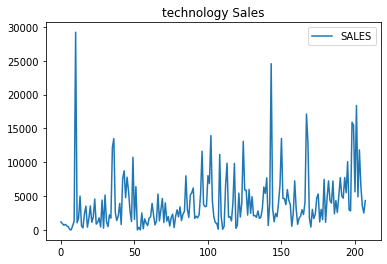

In [376]:
#check for stationarity no trends, consitant variance
#use aughmented dicky fuller test
from statsmodels.tsa.stattools import adfuller
results = adfuller(order_detail_weekly['SALES'])
#check the results object [0] is t stat more neg is more stationary 
# [1] is the p value if below 0.05 then reject null and data is stationarity 
print(results[1])
#passes as stationary, no need for differencing 
sns.lineplot(data=order_detail_weekly)
plt.title(f'{category} Sales')
plt.show()
#even though data is stationary, we can see a seasonal trend

In [383]:
#using SARIMAX model for predictions given seasonality of data 
import pmdarima as pm 
from statsmodels.tsa.statespace.sarimax import SARIMAX
#using pmd package for order selection
#fill in the args for potential ordering solutions and use stepwise for smarter search 
results_object = pm.auto_arima(order_detail_weekly['SALES'],
                        d=0,
                        start_p = 1,
                        start_q = 1,
                        max_p = 3,
                        max_q = 3,
                        seasonal=True,
                        m=51,
                        D=1,
                        start_P = 1,
                        start_Q = 1,
                        max_P = 2,
                        max_Q = 2,
                        information_criterion = 'aic',
                        trace = True,
                        error_action = 'ignore',
                        stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,1,1)[51] intercept   : AIC=3074.793, Time=12.43 sec
 ARIMA(0,0,0)(0,1,0)[51] intercept   : AIC=3139.761, Time=0.10 sec
 ARIMA(1,0,0)(1,1,0)[51] intercept   : AIC=3094.078, Time=1.47 sec
 ARIMA(0,0,1)(0,1,1)[51] intercept   : AIC=inf, Time=4.96 sec
 ARIMA(0,0,0)(0,1,0)[51]             : AIC=3140.272, Time=0.16 sec
 ARIMA(1,0,1)(0,1,1)[51] intercept   : AIC=inf, Time=11.41 sec
 ARIMA(1,0,1)(1,1,0)[51] intercept   : AIC=3092.350, Time=4.98 sec
 ARIMA(1,0,1)(2,1,1)[51] intercept   : AIC=inf, Time=44.59 sec
 ARIMA(1,0,1)(1,1,2)[51] intercept   : AIC=inf, Time=42.67 sec
 ARIMA(1,0,1)(0,1,0)[51] intercept   : AIC=3140.570, Time=0.71 sec
 ARIMA(1,0,1)(0,1,2)[51] intercept   : AIC=3092.219, Time=15.74 sec
 ARIMA(1,0,1)(2,1,0)[51] intercept   : AIC=3091.072, Time=17.06 sec
 ARIMA(1,0,1)(2,1,2)[51] intercept   : AIC=inf, Time=45.53 sec
 ARIMA(0,0,1)(1,1,1)[51] intercept   : AIC=3094.456, Time=2.61 sec
 ARIMA(1,0,0)(1,1,1)[51] intercept   

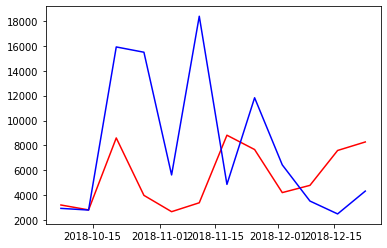

In [384]:
#best model by aic is SARIMA(1,0,2)(1,1,0=1)AIC=3091
#use the predict method to predict the last 12 period (Q4)
forecast = results_object.predict(n_periods=12)
#plot the forecast
plt.figure()
plt.plot(order_detail_weekly.ORDER_WEEK[-12:],
         forecast,
         color='red')
plt.plot(order_detail_weekly.ORDER_WEEK[-12:],
         order_detail_weekly.SALES[-12:],
         color ='blue')
plt.show()

The mean absolute error of the model is 3004.4040806328658


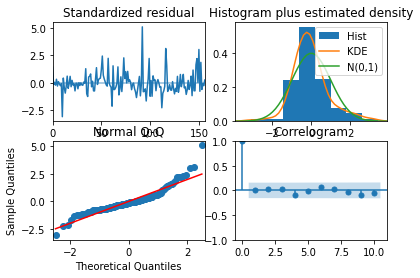

In [385]:
#report Mean Absolute error of residuals
residuals = results_object.resid()
mae = np.mean(np.abs(residuals))
print(f'The mean absolute error of the model is {mae}')
#lastly we want to evaluate that residuals are uncorelated to our predictions to ensure a sound model
#plot diagnositics to check 
results_object.plot_diagnostics()
plt.show()
#standard residuals should have no pattern
#qq plot should follow the line to should residuals are normally distributed 
# hist and correlogram I dont use as much but show distribution and significance 
#graphs show a little skewed distribution of the error. 
#Suggesting there is some model improvement we can make